In [70]:
# Imports

import numpy as np
import scanpy as sc
import os
import pandas as pd
import bbknn
# %%time

In [71]:
# Single Cell settings

sc.settings.verbosity = 4
sc.settings.set_figure_params(80) 
sc.settings.file_format_figures = 'png'
sc.settings.savefigs = False
use_first_n_samples = 0
full_sparse = False

# Batch 

In [72]:
def processing_batch(adata, neighbors = 15, key='batch',reso=0.4): # Higher resolution yields more leiden clusters 
    sc.pp.scale(adata, max_value=10)
    sc.tl.pca(adata, svd_solver='arpack')
    sc.logging.print_memory_usage()
    sc.pp.neighbors(adata, n_neighbors=neighbors)
    sc.pl.pca_variance_ratio(adata, log=True)
    bbknn.bbknn(adata, batch_key=key, neighbors_within_batch=2, metric='euclidean', n_pcs=30, trim=None)
    sc.tl.umap(adata)
    sc.tl.leiden(adata, resolution=reso)
    sc.pl.umap(adata, color='leiden')

In [73]:
#adata after QC
adata = sc.read(r'/Code/data/single_cell/animals/turtle/turtle_3/''turtle_after_qc.h5ad') 

# If the anndata object is processed and contains the raw data in adata.raw run -  adata = adata.raw.to_adata()

In [ ]:
# adata.obs['batch_key'] = adata.obs['Sample'].astype('str') + '_' + adata.obs['treatment'].astype('str')

normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    Gene indices [14748, 15552, 15554] fell into a single bin: their normalized dispersion was set to 1.
    Decreasing `n_bins` will likely avoid this effect.
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


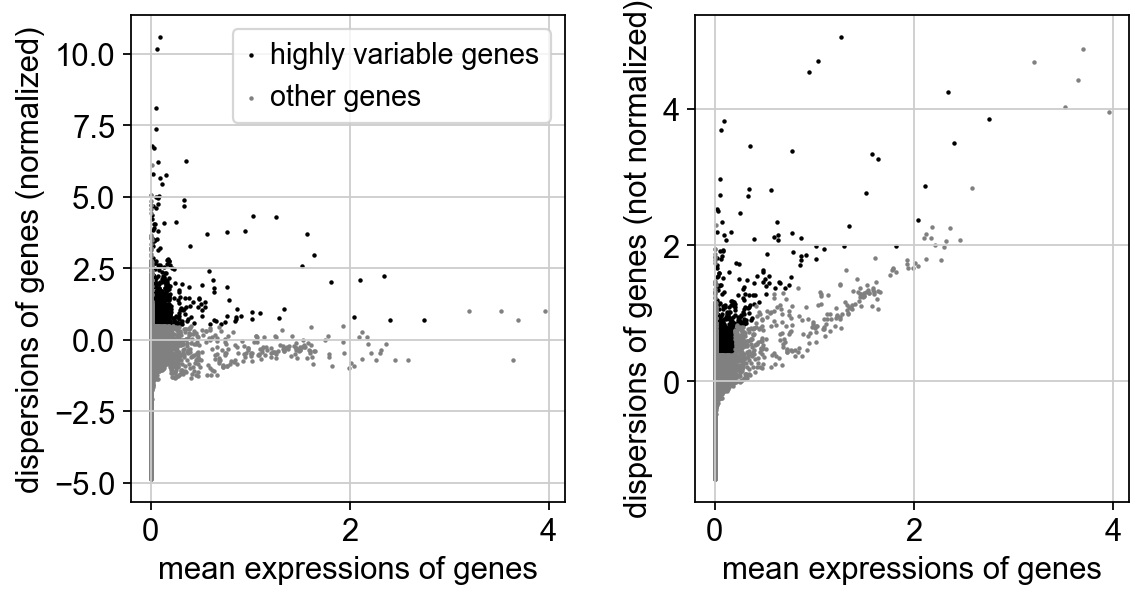

In [74]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)
adata.raw = adata
# adata = adata[:, adata.var.highly_variable] # For filtering non Highly variable genes. We usually keep all the genes. 

In [ ]:
# sc.pp.regress_out(adata, ['total_counts','pct_counts_MT']) 

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
    ... clipping at max_value 10
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:03)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)
Memory usage: current 1.18 GB, difference -0.94 GB
computing neighbors
    computing neighbors
    using 'X_pca' with n_pcs = 50
    computed neighbors (0:00:00)
    computed connectivities (0:00:00)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


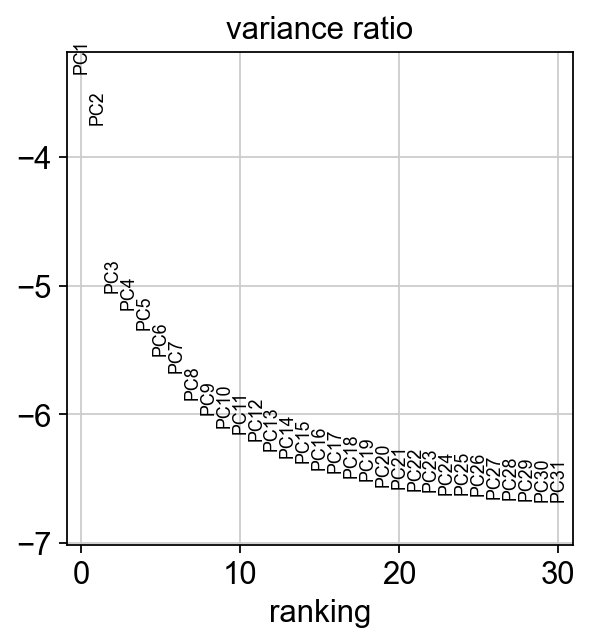

computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing UMAP


  0%|          | 0/200 [00:00<?, ?it/s]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:07)
running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


c:\Python\Python310\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


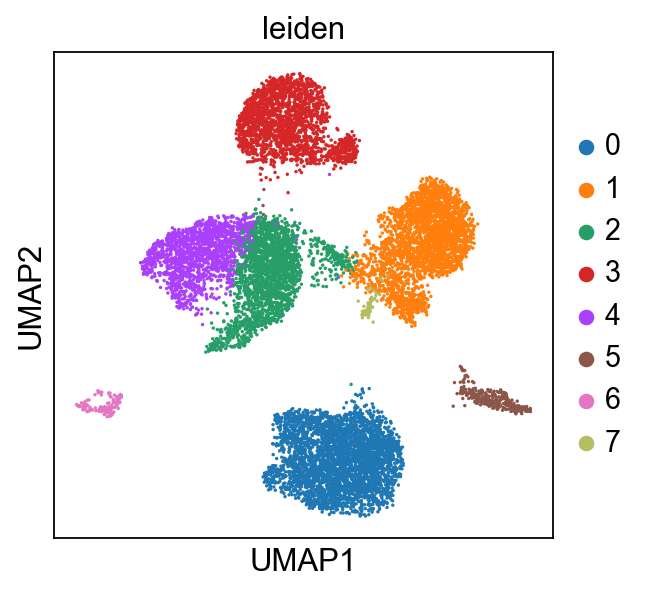

In [75]:
processing_batch(adata, key='treatment') # Starting with a low resolution of leiden clustering

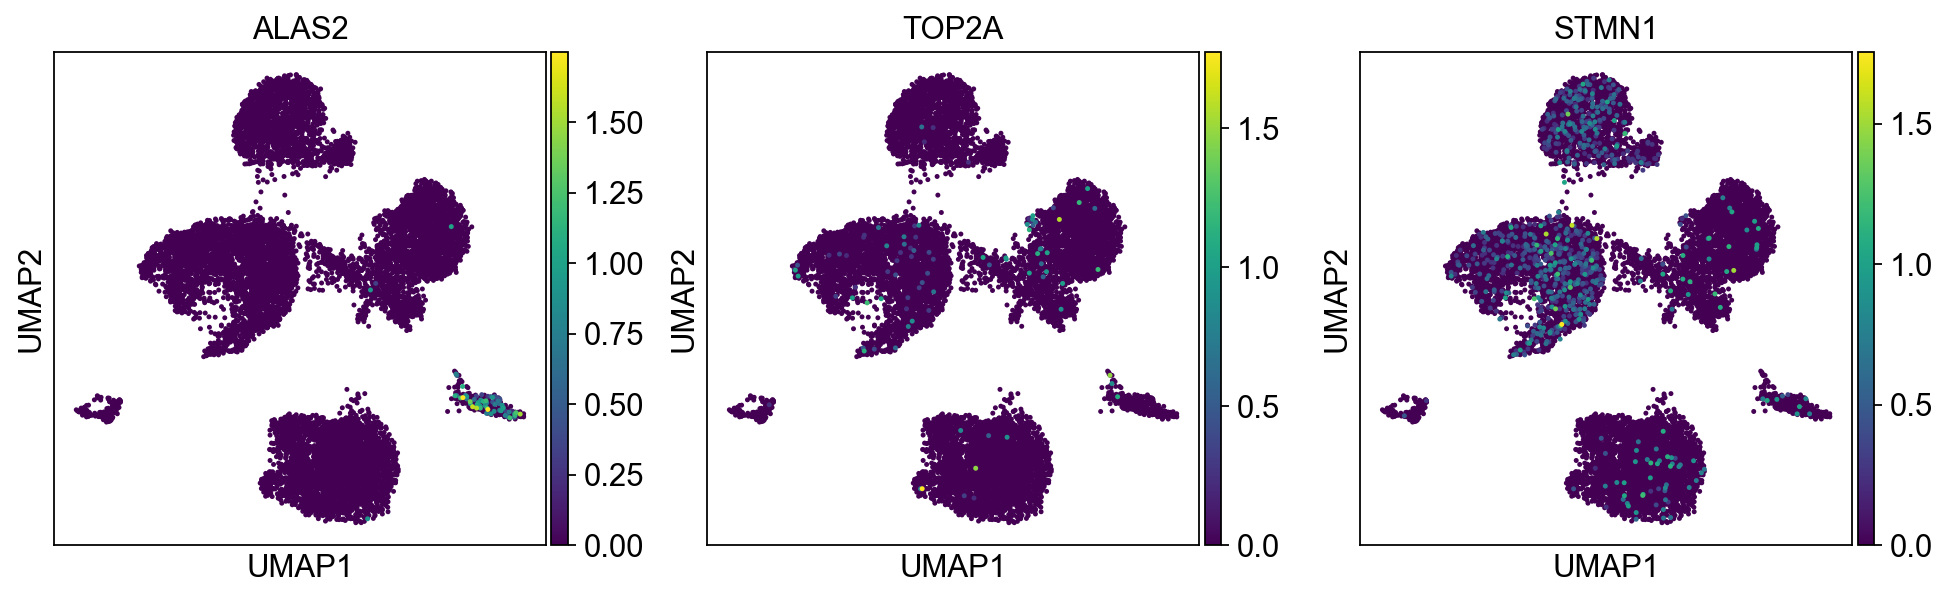

In [89]:
# Colors the gene of interest
# sc.pl.umap(adata, color='IL6', size=50) # size of the dots
# sc.pl.umap(adata, color='CD3E', size=5) # T cells
# sc.pl.umap(adata, color='S100A10') # monocytes
# sc.pl.umap(adata, color=['PLEK','CD36','B2M'])
# sc.pl.umap(adata, color=['B2M','CLU','F13A1','GNAS','TAGLN2','OAZ1'], size=5) #platlets
# sc.pl.umap(adata, color=['ALAS2','TOP2A','STMN1'], size=20)

> Restoring annotations of the LF and UNST samples

In [ ]:
cdata = sc.read(r'/Code/data/single_cell/animals/turtle/turtle_3/''turtle_after_qc.h5ad')

cdata

In [ ]:
cdata.obs['index_new'] = cdata.obs.index.astype('str').copy()

In [ ]:
for i in cdata.obs.index:
    if i.split('_')[-1] == 'control':
        cdata.obs.at[i,'index_new'] = i.split('_')[0] + '-UNST'
    else:
        cdata.obs.at[i,'index_new'] = i.replace('_','-')
    idx  =  cdata.obs.at[i,'index_new'].split('-')
    cdata.obs.at[i,'index_new'] = idx[0] +'-'+ idx[1] +'-'+ idx[-1] +'-'+ str.capitalize(idx[-2])

In [ ]:
# metadata_clf = dict(zip(cdata.obs.index_new, cdata.obs.cell_type))

In [ ]:
# adata= sc.read('mid_way_komodo.h5ad')

In [ ]:
# adata.obs['cell_type'] = adata.obs.index.map(metadata_clf).astype('str')

In [ ]:
# adata.obs['category'] = adata.obs['cell_type'].copy()

In [ ]:
def projecting_type(adata, null_char, reso):
    sc.tl.leiden(adata, resolution=reso)
    catdict = dict(zip(adata[adata.obs.cell_type != null_char].obs.cell_type, adata[adata.obs.cell_type != null_char].obs.category))
    newgutcellsdict = {}
    for leidenc in sorted(set(adata.obs.leiden)):   
        leidenc = str(leidenc)
        print('\n\n' + leidenc)
        newgutcellsdict[leidenc] = adata[adata.obs.leiden == leidenc].obs.cell_type.value_counts().index[0]
        if adata[adata.obs.leiden == leidenc].obs.cell_type.value_counts().index[0] == null_char:
            if len(adata[adata.obs.leiden == leidenc].obs.cell_type.value_counts().index)!= 1:
                newgutcellsdict[leidenc] = adata[adata.obs.leiden == leidenc].obs.cell_type.value_counts().index[1]
            else:
                newgutcellsdict[leidenc] = 'Re-do'
                    
        print(f'Value recieved for {leidenc} is {newgutcellsdict[leidenc]} \n')

        print(adata[adata.obs.leiden == leidenc].obs.cell_type.value_counts().head(5))

    newgutcellsnew = adata[adata.obs.cell_type == null_char].copy()
    newgutcellsnew.obs['cell_type'] = newgutcellsnew.obs['leiden'].map(newgutcellsdict).astype('category')
    newgutcellsnew.obs['category'] = newgutcellsnew.obs['cell_type'].map(catdict).astype('category')
    adata.obs.update(newgutcellsnew.obs)
    sc.pl.umap(adata, color = 'cell_type', frameon=False, size=5)
    sc.pl.umap(adata, color = 'category', frameon=False, size=5)
    sc.pl.umap(adata, color = 'leiden', frameon=False, size=5)

    return adata

In [ ]:
%%time
cells_dict = []
for cluster in set(adata.obs.leiden):
    new_cluster = adata[adata.obs.leiden == cluster].copy()
    bbknn.bbknn(new_cluster, batch_key = 'batch_key', neighbors_within_batch=2, metric='euclidean', n_pcs=30, trim=None)
    sc.tl.umap(new_cluster)
    sc.tl.leiden(new_cluster, resolution=3)
    sc.pl.umap(new_cluster,color =['cell_type','leiden'])
    projecting_type(new_cluster,'nan',3)
    cells_dict.append(dict(zip(new_cluster.obs.index,new_cluster.obs.cell_type)))

In [ ]:
# result_dict = {k: v for d in cells_dict for k, v in d.items()}

In [ ]:
# adata.obs['cell_type_new'] = adata.obs.index.map(result_dict).astype('str')

In [ ]:
# sc.pl.umap(adata, color= 'cell_type_new', size=20)

In [ ]:
# sc.pl.dotplot(adata, find_gene('TNF'), groupby='treatment', standard_scale=None)

In [ ]:
redo = adata[adata.obs.cell_type_new == 'Re-do']
sc.tl.leiden(redo, resolution=0.01)

In [ ]:
redo.obs['cell_type_new'] = redo.obs.leiden.map({'0':'B','1':'T','2':'T','3':'T','4':'T','5':'T','6':'T','7':'T'}).astype('str')

In [ ]:
sc.pl.umap(redo, color=['IGHM','CD3D','cell_type_new'])

In [ ]:
adata.obs.update(redo.obs)

In [ ]:
sc.pl.umap(adata,color='cell_type_new')

In [ ]:
meta = adata.obs.copy()

In [ ]:
adata = sc.read('komodo_after_qc.h5ad')

In [ ]:
adata.obs = meta.copy()

In [ ]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)
adata.raw = adata

# Rank genes - DE analysis

In [ ]:
sc.tl.rank_genes_groups(adata, 'cell_type_new', method='wilcoxon') # Can also be 'cell_type' once annotated
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)
pd.set_option("display.max_columns", None)
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(20)

In [ ]:
rbc = adata[adata.obs.cell_type_new == 'Monocyte']
sc.tl.rank_genes_groups(rbc, 'treatment', method='wilcoxon') # Can also be 'cell_type' once annotated
sc.pl.rank_genes_groups(rbc, n_genes=25, sharey=False)
pd.set_option("display.max_columns", None)
pd.DataFrame(rbc.uns['rank_genes_groups']['names']).head(20)

In [ ]:
adata.write('komodo_processed_annotated.h5ad')

In [ ]:
adata.obs.leiden = adata.obs.leiden.astype('str')
for i in adata.obs_names:
    if adata.obs.at[i,'leiden'] ==0:
        adata.obs.at[i,'leiden'] = '0'
adata.obs.leiden = adata.obs.leiden.astype('category')

In [ ]:
# ?FROM\ BATS
GENES = ["CSF3R",'CD300A', "CCRL2", "G0S2","FCGR3A",'FCGR3','CD16',"CX3CR1", #CD16 Mono 
           "CD14",'VCAN', "F13A1","MAFB","IFNB1", #CD14 Mono ;FCGR1A, S100A12 CLEC4A_LOC107498332
           "IL18",
            'CD1A','XCR1','CD200A','CD200','ITGAM', 
            "HLA-DRA", #cDC2
            'BATF3','LAMP3',
           "IRF8","TCF4",'IL7R',"CD4","FOXP3",'CTLA4','LEF1','CCR7','TCF7','CXCR6','CD8A','CD8B','CD7','GZMB','KLRD1','NCR1','CD3D','CD3E','CD3G',
'S100A8',
'FCGR4',
'LY6C2',
'FSCN1',
'CCR7',
'TCF4',
'BST2', 
'NKG7',
'NCR1',
'MS4A1','HLA-DPB1',
 'HLA-DRA',
 'HLA-DMA','CD74','ALAS2']

GENES_K =[i for i in GENES if i in adata.var_names]

In [ ]:
clusgene = list(pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(50)['3'])

In [ ]:
sc.pl.umap(adata, color = ['SERPINE1','CD36','PLEK','PECAM1'])

- Cluster 3 has a gprofiler file - full of coagulation and blood clotting terms, including platelete degranulation and aggregations (based on 50 DE genes).
- 1 DE gene found which coult possibly support it being platlets - SERPINE1 (by PangaoDB), CD36, PLEK 
- B2M, TMSB4X, ACTB - High level expression (mostly of B2M) is sometimes associated with Platlets. https://doi.org/10.1038/s41598-021-94003-z

 platlete_markers = ['PLEK','CD36','SERPINE1','B2M']

c:\Python\Python310\lib\site-packages\scanpy\plotting\_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


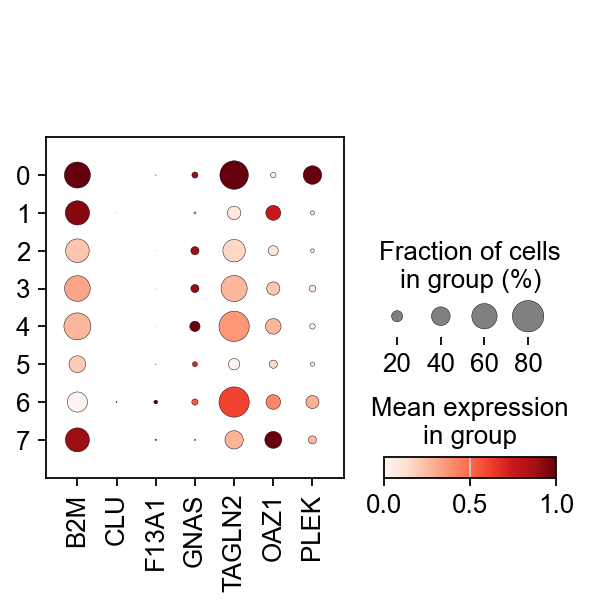

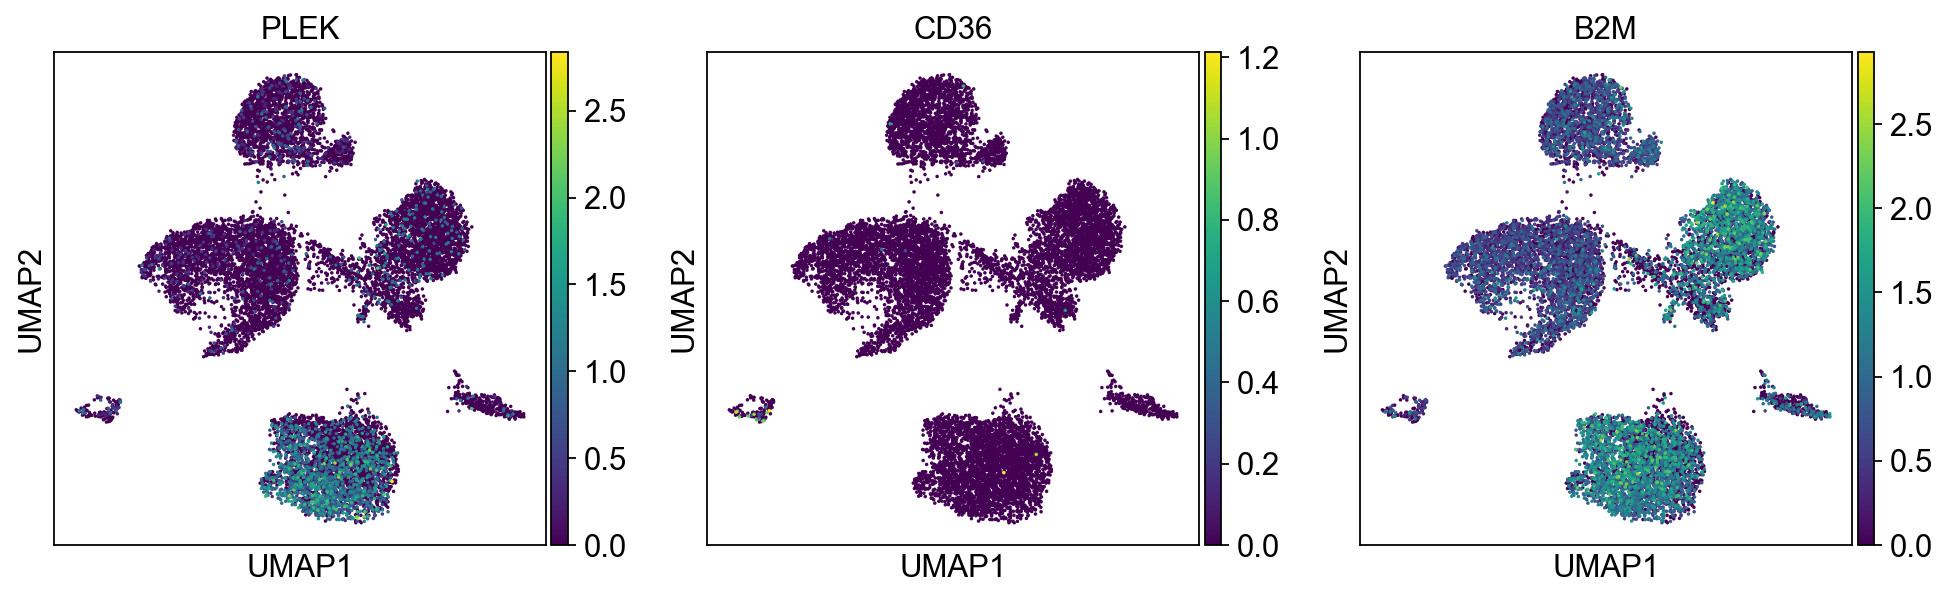

In [101]:
platlet = ['B2M','PPBP','TMSB4X','ACTB','FTL','CLU','PF4','F13A1','GNAS','SPARC','PTMA','TAGLN2','OAZ1','OST4', 'PLEK']
platlet = [i for i in platlet if i in adata.var_names]
sc.pl.dotplot(adata, platlet, groupby='leiden', standard_scale='var')
sc.pl.umap(adata, color = ['PLEK','CD36','B2M'], size=10) #'SERPINE1'

In [ ]:
# sc.tl.leiden(adata,resolution=0.4)
clusgene = list(pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(100)['1'])
sc.pl.dotplot(adata,[i for i in clusgene if i.startswith('RP')==False], groupby='leiden', standard_scale='var')

# MARKERS

In [ ]:
monocytes = ['MRC1','CCL8-1','C1QA','TXN','MAFB','TYROBP','LYZ','SPI1','LGALS3','RGS2','CSTA-1','S100A4','CSF1R']
meutrophils = ['S100A10','CSF1','IL1R2','CFP'] # CFP marker for monocytes as well
MAFB_monocytes =['MAFB','DUSP1','JUNB','TNF','KLF4','NFKBIA','NFKBIZ']
T_cells = ['CD3D','CD247','TCF7','GPR183','GPR171']
B_cells = ['IGHM','CD79A','PLAC8','CD74-1'] # ,'HLA-DRA-1' as well 
RBC = ['HBA','HBM','ALAS2'] 
RBC_pre = ['HBA','HBM','ALAS2','TOP2A','STMN1']
dc = ['XCR1','CD200','IL18','CST3','CSTA-1','SPIB','IRF8','HLA-DRA-1'] #ALL dcS
platelets = ['PLEK','CD36','SERPINE1','PECAM1','B2M']
# pDC = ['IRF8','SPIB','HLA-DRA-1','CD3D','IGHM','CST3'] # No XCR1, IL18 and CD200 like in other DC cluster

In [ ]:
cell_order = ['Heterophil','Monocyte','Monocyte_MRC1','Monocyte_CCL8','Monocyte_C1Q_CCL8','Monocyte_TXN','Monocyte_MAFB','cDC','B','T','RBC','Erythroid_precursor','Platelet']
sc.pl.dotplot(adata,meutrophils + monocytes + MAFB_monocytes + dc + B_cells + T_cells + RBC + RBC_pre + platelets, categories_order=cell_order, groupby='cell_type_new', standard_scale='var')

In [ ]:
sc.pl.umap(adata,color=['CD3D','IGHM','HBA','LYZ','MRC1'])

In [ ]:
celltype = {'0':'T_cell','1':'B_cell','2':'Myeloid','3':'3','4':'RBC','5':'B_cell'}

In [ ]:
adata.obs['cell_type'] = adata.obs.leiden.map(celltype).astype('category')

In [ ]:
sc.pl.dotplot(adata,B_cells+monocytes+RBC+T_cells,groupby='cell_type',standard_scale='var')

In [ ]:
sc.pl.dotplot(adata,find_gene('TOP2A'), groupby='leiden', standard_scale=None)

In [ ]:
# sc.tl.leiden(adata, resolution=1)

# sc.pl.umap(adata,color =['C1QA', 'C1QC', 'C1QB','LYZ','IL1B','F13A1','VCAN','FABP4','leiden'],size=10)
sc.pl.umap(adata,color =['IRF8','leiden','cell_type'],size=10)

In [ ]:
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', color='cell_type', groups=['RBC','3'])

In [ ]:
sc.pl.umap(adata,color='STMN1')

# Sub-clustering - B

In [ ]:
clustert = adata[adata.obs.cell_type=='B_cell']

In [ ]:
bbknn.bbknn(clustert, batch_key='batch', neighbors_within_batch=2, metric='euclidean', n_pcs=30,trim=None)
sc.tl.umap(clustert)
sc.tl.leiden(clustert, resolution=0.4)
sc.pl.umap(clustert,color =['leiden','CD79A','IGHM',])

In [ ]:
sc.tl.rank_genes_groups(clustert, 'leiden', method='wilcoxon') # Can also be 'cell_type' once annotated
sc.pl.rank_genes_groups(clustert, n_genes=25, sharey=False)
pd.set_option("display.max_columns", None)
pd.DataFrame(clustert.uns['rank_genes_groups']['names']).head(20)

In [ ]:
# sc.tl.leiden(clustert,resolution=0.4)
clusgene = list(pd.DataFrame(clustert.uns['rank_genes_groups']['names']).head(100)['4'])
sc.pl.dotplot(clustert,[i for i in clusgene[:50] if i.startswith('RP')==False],groupby='leiden',standard_scale=None)
sc.pl.dotplot(clustert,['XCR1','CSTA-1','IRF8','CD200','HLA-DRA-1','IL18','FSCN1','TOP2A','STMN1','CD83','MARCKSL1','ALAS2','ENO1'],groupby='leiden',standard_scale='var')


In [ ]:
sc.pl.umap(clustert,color =find_gene('sirpa'),size=30)
clusgene = list(pd.DataFrame(clustert.uns['rank_genes_groups']['names']).head(100)['4'])
sc.pl.dotplot(clustert,[i for i in clusgene if i.startswith('RP')==False],groupby='leiden',standard_scale='var')

In [ ]:
sc.pl.umap(clustert,color =find_gene('PF'),size=30)
sc.pl.umap(clustert,color =['FSCN1','CCR7','CD83','MARCKSL1','ALAS2','IGHM','STMN1','CD79A','CD79B'],size=40)

In [ ]:
sc.pl.umap(clustert,color =['XCR1','CSTA-1','IRF8','CD200','IL18']+find_gene('PLAC8'))

In [ ]:
sc.pl.dotplot(clustert,find_gene('TCF4'),groupby='leiden',standard_scale=None)

In [ ]:
clus6 = clustert[clustert.obs.leiden=='6']

In [ ]:
bbknn.bbknn(clus6, batch_key='batch', neighbors_within_batch=2, metric='euclidean', n_pcs=30,trim=None)
sc.tl.umap(clus6)
sc.tl.leiden(clus6, resolution=0.4)
sc.pl.umap(clus6,color =['leiden','XCR1','CD200','CSTA-1','IRF8','HLA-DRA-1','IL18'],)

In [ ]:
sc.tl.rank_genes_groups(clus6, 'leiden', method='wilcoxon') # Can also be 'cell_type' once annotated
sc.pl.rank_genes_groups(clus6, n_genes=25, sharey=False)
pd.set_option("display.max_columns", None)
pd.DataFrame(clus6.uns['rank_genes_groups']['names']).head(20)

In [ ]:
celltypes = {'0':'B','1':'B','2':'B','3':'B','4':'B','5':'Erythroid_precursor','6':'DC'}
clustert.obs['cell_type'] = clustert.obs.leiden.map(celltypes).astype('category')

In [ ]:
adata.obs.update(clustert.obs)

> In order to find more specific cell types known markers from  Elmentaite, R. et al. Cells of the human intestinal tract mapped across space and time. Nature 597, (2021) will be checked for expression in the sub clusters

# subclus myeloids

In [ ]:
sc.pl.umap(adata,color='cell_type')

In [ ]:
clusterm = adata[adata.obs.cell_type=='Myeloid']

In [ ]:
bbknn.bbknn(clusterm, batch_key='batch', neighbors_within_batch=2, metric='euclidean', n_pcs=30,trim=None)
sc.tl.umap(clusterm)
sc.tl.leiden(clusterm, resolution=0.4)
sc.pl.umap(clusterm,color =['leiden','LYZ','MRC1','C1QA',])

sc.tl.rank_genes_groups(clusterm, 'leiden', method='wilcoxon') # Can also be 'cell_type' once annotated
sc.pl.rank_genes_groups(clusterm, n_genes=25, sharey=False)
pd.set_option("display.max_columns", None)
pd.DataFrame(clusterm.uns['rank_genes_groups']['names']).head(20)

In [ ]:
sc.pl.rank_genes_groups_dotplot(clusterm,groups=['7'],n_genes=15, standard_scale='var')

In [ ]:
sc.pl.rank_genes_groups_dotplot(adata, n_genes=3, standard_scale='var')

In [ ]:
sc.pl.dotplot(clusterm, monocytes,groupby='leiden'
, standard_scale='var')

In [ ]:
# sc.pl.umap(clusterm,color =find_gene('CSF'),size=30)
sc.pl.umap(clusterm,color =find_gene('s100'),size=30)

clusgene = list(pd.DataFrame(clusterm.uns['rank_genes_groups']['names']).head(100)['7'])

sc.pl.dotplot(clusterm,find_gene('s100'),groupby='leiden',standard_scale=None)

In [ ]:
sc.pl.dotplot(clusterm,'',groupby='leiden',standard_scale=None)

In [ ]:
clus4 = clusterm[clusterm.obs.leiden=='4']

In [ ]:
bbknn.bbknn(clus4, batch_key='batch', neighbors_within_batch=2, metric='euclidean', n_pcs=30,trim=None)
sc.tl.umap(clus4)
sc.tl.leiden(clus4, resolution=0.4)
sc.pl.umap(clus4,color =['leiden','LYZ','MRC1','C1QA',])

sc.tl.rank_genes_groups(clus4, 'leiden', method='wilcoxon') # Can also be 'cell_type' once annotated
sc.pl.rank_genes_groups(clus4, n_genes=25, sharey=False)
pd.set_option("display.max_columns", None)
pd.DataFrame(clus4.uns['rank_genes_groups']['names']).head(20)

In [ ]:
sc.pl.umap(clus4,color=['S100A10','CSF1','IL1R2','CFP'])

In [ ]:
genes = ['S100A10','CSF1','IL1R2','CFP','MAFB','DUSP1','JUNB','TNF','KLF4','NFKBIA','NFKBIZ'] +find_gene('NFK')
sc.pl.dotplot(clus4,genes,groupby='leiden',standard_scale='var')
sc.pl.umap(clus4,color=genes)

In [ ]:
NEUT = ['S100A10','CSF1','IL1R2','CFP']
MAFB_MONO =['MAFB','DUSP1','JUNB','TNF','KLF4','NFKBIA','NFKBIZ']

In [ ]:
celltypes = {'0':'Monocyte','1':'Monocyte_CCL8','2':'Monocyte','3':'Monocyte','4':'Monocyte','5':'Monocyte_MRC1','6':'Monocyte_C1Q_CCL8','7':'Monocyte_TXN'}
clusterm.obs['cell_type'] = clusterm.obs.leiden.map(celltypes).astype('category')
celltypes = {'0':'Monocyte','1':'Monocyte_CCL8','2':'Monocyte_MAFB','3':'Monocyte_MAFB','4':'Neutrophil'}
clus4.obs['cell_type'] = clus4.obs.leiden.map(celltypes).astype('category')
clusterm.obs.update(clus4.obs)
sc.tl.leiden(clusterm, resolution=0.4)

In [ ]:
sc.pl.umap(clusterm, color ='cell_type')

In [ ]:
sc.tl.rank_genes_groups(clusterm, 'cell_type', method='wilcoxon') # Can also be 'cell_type' once annotated
sc.pl.rank_genes_groups(clusterm, n_genes=25, sharey=False)
pd.set_option("display.max_columns", None)
pd.DataFrame(clusterm.uns['rank_genes_groups']['names']).head(20)

In [ ]:
sc.pl.rank_genes_groups_dotplot(clusterm, n_genes=6,standard_scale='var')

In [ ]:
sc.pl.umap(clusterm, color ='S100A4')

In [ ]:
adata.obs.update(clusterm.obs)

In [ ]:
sc.tl.leiden(adata, resolution=0.4)

# subclustering T cells

In [ ]:
clustert = adata[adata.obs.leiden.isin(['0','6'])]

In [ ]:
bbknn.bbknn(clustert, batch_key='batch', neighbors_within_batch=2, metric='euclidean', n_pcs=30,trim=None)
sc.tl.umap(clustert)
sc.tl.leiden(clustert, resolution=0.4)
sc.pl.umap(clustert,color =['leiden','CD3D','CD8A',])

sc.tl.rank_genes_groups(clustert, 'leiden', method='wilcoxon') # Can also be 'cell_type' once annotated
sc.pl.rank_genes_groups(clustert, n_genes=25, sharey=False)
pd.set_option("display.max_columns", None)
pd.DataFrame(clustert.uns['rank_genes_groups']['names']).head(20)

In [ ]:
sc.tl.dendrogram(clustert ,groupby='leiden')

In [ ]:
sc.pl.rank_genes_groups_dotplot(clustert, n_genes=6,standard_scale='var')

In [ ]:
clusgene = list(pd.DataFrame(clustert.uns['rank_genes_groups']['names']).head(100)['3'])
sc.pl.dotplot(clustert,[i for i in clusgene[:50] if i.startswith('RP')==False],groupby='leiden',standard_scale=None)
sc.pl.dotplot(clustert,['TOP2A','STMN1'],groupby='leiden',standard_scale=None)

# Sub clustering RBCs

In [ ]:
rbc = adata[adata.obs.cell_type=='RBC']

In [ ]:
bbknn.bbknn(rbc, batch_key='batch', neighbors_within_batch=2, metric='euclidean', n_pcs=30,trim=None)
sc.tl.umap(rbc)
sc.tl.leiden(rbc, resolution=0.7)
sc.pl.umap(rbc,color =['leiden','HBA','CD3D',])

sc.tl.rank_genes_groups(rbc, 'leiden', method='wilcoxon') # Can also be 'cell_type' once annotated
sc.pl.rank_genes_groups(rbc, n_genes=25, sharey=False)
pd.set_option("display.max_columns", None)
pd.DataFrame(rbc.uns['rank_genes_groups']['names']).head(20)

In [ ]:
t_in_rbc = list(rbc[rbc.obs.leiden=='10'].obs.index)

In [ ]:
adata.obs.cell_type = adata.obs.cell_type.astype('str')
for i in adata.obs_names:
    if i in t_in_rbc:
        adata.obs.at[i,'cell_type'] = 'T'
    else:
        pass

# Platletes subclustering 

In [ ]:
plat = adata[adata.obs.leiden =='3']

In [ ]:
plat.obs.batch.value_counts()

In [ ]:
bbknn.bbknn(plat, batch_key='batch', neighbors_within_batch=2, metric='euclidean', n_pcs=30,trim=None)
sc.tl.umap(plat)
sc.tl.leiden(plat, resolution=0.4)
sc.pl.umap(plat,color =['leiden','PLEK','B2M',])

sc.tl.rank_genes_groups(plat, 'leiden', method='wilcoxon') # Can also be 'cell_type' once annotated
sc.pl.rank_genes_groups(plat, n_genes=25, sharey=False)
pd.set_option("display.max_columns", None)
pd.DataFrame(plat.uns['rank_genes_groups']['names']).head(20)

In [ ]:
pdc = ['SPIB','HLA-DRA-1','IRF8'] #together with differemt CST3 CSTK etc, and CD3D, IGHM ,CD79 (pDC often expressed lymphocyte markers)

In [ ]:
GENE = 'TUBA1A-1'
sc.pl.umap(plat,color=find_gene(GENE))
sc.pl.dotplot(plat,dc,groupby='leiden',standard_scale=None)
sc.pl.umap(plat,color=['S100A11'])

_____________________________

In [ ]:
clus5 = plat[plat.obs.leiden=='5'].obs.index

In [ ]:
adata.obs.cell_type = adata.obs.cell_type.astype('str')
for i in adata.obs_names:
    if adata.obs.at[i,'leiden']=='3':
        adata.obs.at[i,'cell_type'] = 'Platelet'
    if i in clus5:
        adata.obs.at[i,'cell_type'] = 'pDC'
    elif  adata.obs.at[i,'cell_type']=='Neutrophil':
        adata.obs.at[i,'cell_type'] = 'Heterophil'
    elif  adata.obs.at[i,'cell_type']=='DC':
        adata.obs.at[i,'cell_type'] = 'cDC'

    else:
        pass

In [ ]:
adata.obs.cell_type.value_counts()

In [ ]:
sc.pl.umap(adata,color='cell_type',title='',frameon=False)


In [ ]:
adata.obs.cell_type = adata.obs.cell_type.astype('str')
for i in adata.obs_names:
    if adata.obs.at[i,'leiden'] in ['0','6']:
        adata.obs.at[i,'cell_type'] = 'T'
    else:
        if i 
        pass
adata.obs.cell_type = adata.obs.cell_type.astype('category')


In [ ]:
sc.pl.umap(adata,color='cell_type',frameon=False,title='')


In [ ]:
adata.write('komodo_lf_ctrl_processed.h5ad')

In [ ]:
sc.tl.rank_genes_groups(adata, 'cell_type', method='wilcoxon') # Can also be 'cell_type' once annotated
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)
pd.set_option("display.max_columns", None)
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(20)

In [ ]:
monocytes = ['MRC1','CCL8-1','C1QA','TXN','MAFB','TYROBP','LYZ','SPI1','LGALS3','RGS2','CSTA-1','S100A4','CSF1R']
meutrophils = ['S100A10','CSF1','IL1R2','CFP'] # CFP marker for monocytes as well
MAFB_monocytes =['MAFB','DUSP1','JUNB','TNF','KLF4','NFKBIA','NFKBIZ']
T_cells = ['CD3D','CD247','TCF7','GPR183','GPR171']
B_cells = ['IGHM','CD79A','PLAC8','CD74-1'] # ,'HLA-DRA-1' as well 
RBC = ['HBA','HBM','ALAS2'] 
RBC_pre = ['HBA','HBM','ALAS2','TOP2A','STMN1']
dc = ['XCR1','CD200','IL18','CST3','CSTA-1','IRF8','HLA-DRA-1'] #ALL dcS
platelets = ['PLEK','CD36','SERPINE1','PECAM1','B2M']


In [ ]:
adata.obs.replace({'pDC':'B'},inplace=True)

In [ ]:
cell_order = ['Heterophil','Monocyte','Monocyte_MRC1','Monocyte_CCL8','Monocyte_C1Q_CCL8','Monocyte_TXN','Monocyte_MAFB','cDC','B','T','RBC','Erythroid_precursor','Platelet']
sc.pl.dotplot(adata,meutrophils+monocytes+MAFB_monocytes+dc+B_cells+T_cells+RBC+RBC_pre+platelets,categories_order =cell_order ,groupby='cell_type',standard_scale='var')

In [ ]:
# PDCs might be just B cells 

In [ ]:
pb = adata[adata.obs.cell_type.isin(['B','pDC'])]
bbknn.bbknn(pb, batch_key='batch', neighbors_within_batch=2, metric='euclidean', n_pcs=30,trim=None)
sc.tl.umap(pb)
sc.tl.leiden(pb, resolution=0.4)
sc.pl.umap(pb,color =['leiden','PLEK','B2M',])

sc.tl.rank_genes_groups(pb, 'cell_type', method='wilcoxon') # Can also be 'cell_type' once annotated
sc.pl.rank_genes_groups(pb, n_genes=25, sharey=False)
pd.set_option("display.max_columns", None)
pd.DataFrame(pb.uns['rank_genes_groups']['names']).head(20)

In [ ]:
adata.write('komodo_lf_ctrl_processed.h5ad')

# Gene search tools

This function returns a list of genes that are present in adata (markers for example) from an input of a general list.

In [93]:
def find_gene(gene):
    GENES= list(adata.raw.var.index[adata.raw.var.index.str.startswith(gene.upper())])
    return GENES

Finds genes that start with X

In [ ]:
GENES= list(adata.raw.var.index[adata.raw.var.index.str.startswith(gene.upper())])
GENES

In [96]:
find_gene('hb')

['HBS1L', 'HBAD', 'HBEGF', 'HBP1']

# Using raw file

In [ ]:
bdata = sc.read('Komodo_raw_with_metadata.h5ad')

In [ ]:
sc.pp.filter_genes(bdata,min_cells=200)

In [ ]:
sc.pp.normalize_total(bdata)
sc.pp.log1p(bdata)
sc.pp.highly_variable_genes(bdata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(bdata)
bdata.raw = bdata

In [ ]:
processing_batch(bdata,key='batch_key')

In [ ]:
sc.pl.umap(bdata,color='cell_type_new')
sc.pl.umap(bdata,color='treatment')
sc.pl.umap(bdata,color='NCF2')

In [ ]:
bdata

In [ ]:
sc.pl.umap(bdata,color='Sample',frameon=False)
sc.pl.umap(bdata,color='leiden',frameon=False)


In [ ]:
rbc = adata[adata.obs.cell_type_new=='Monocyte']
sc.tl.rank_genes_groups(rbc, 'treatment', method='wilcoxon') # Can also be 'cell_type' once annotated
sc.pl.rank_genes_groups(rbc, n_genes=25, sharey=False)
pd.set_option("display.max_columns", None)
pd.DataFrame(rbc.uns['rank_genes_groups']['names']).head(20)

In [ ]:
sc.tl.rank_genes_groups(bdata, 'leiden', method='wilcoxon') # Can also be 'cell_type' once annotated
sc.pl.rank_genes_groups(bdata, n_genes=25, sharey=False)
pd.set_option("display.max_columns", None)
pd.DataFrame(bdata.uns['rank_genes_groups']['names']).head(20)

In [ ]:
sc.pl.rank_genes_groups_dotplot(bdata, n_genes=3, standard_scale='var')


In [ ]:
platelets = ['PLEK','CD36','SERPINE1','PECAM1','B2M']
    

In [ ]:
sc.pl.umap(bdata, color = platelets, frameon=False, ncols=5)

In [ ]:
def find_gene(gene):
    GENES= list(bdata.raw.var.index[bdata.raw.var.index.str.startswith(gene.upper())])
    return GENES

In [ ]:
find_gene('nkg')

In [ ]:
sc.pl.umap(bdata,color=find_gene('tnf'))

In [ ]:
pd.set_option("display.max_rows", None)
[print(i) for i in pd.DataFrame(rbc.uns['rank_genes_groups']['names']).head(100).PIC.to_list()]

In [ ]:
find_gene('ccl8')